In [2]:
import os
import zipfile
import shutil
import glob 

In [3]:
for zip_path, output_dir in [('ACTProject*.zip', 'namadgi/'), ('1533*.zip', 'canberra/')]:
    for archive in glob.glob(zip_path):
        try:
            with zipfile.ZipFile(archive) as z:
                for f in z.namelist():
                    if '_MS_' in f and f.lower().endswith('.jp2'):
                        fname = os.path.join(output_dir, os.path.basename(f))
                        if not os.path.isfile(fname):
                            with open(fname, mode='wb') as out: 
                                shutil.copyfileobj(z.open(f), out)
        except:
            print('Bad file', archive)

Bad file ACTProject-1521-SampleData_SO17001954-2-01_DS_SPOT7_201603182342567_FR1_FR1_SE1_SE1_E149S36_01627.zip
Bad file ACTProject-1521-SampleData_SO17001954-3-01_DS_SPOT6_201603052344389_FR1_FR1_SE1_SE1_E149S36_01871.zip
Bad file ACTProject-1521-SampleData_SO17001954-4-01_DS_SPOT6_201602272348164_FR1_FR1_FR1_FR1_E149S35_06174.zip
Bad file ACTProject-1521-SampleData_SO17001954-5-01_DS_SPOT7_201602212343091_FR1_FR1_FR1_FR1_E149S36_03089.zip
Bad file ACTProject-1521-SampleData_SO17001954-6-01_DS_SPOT6_201602152341097_FR1_FR1_SE1_SE1_E149S36_03170.zip
Bad file ACTProject-1521-SampleData_SO17001954-7-01_DS_SPOT7_201603252339069_FR1_FR1_SE1_SE1_E149S36_04956.zip


In [18]:
import xarray as xr
import pandas as pd
import numpy as np
%matplotlib inline

In [5]:
imgs = sorted(glob.glob('canberra/IMG_SPOT*.JP2'), key=lambda s: s.rsplit('_MS_')[-1])
imgs

['canberra\\IMG_SPOT7_MS_201602092335245_ORT_2187904101_R1C1.JP2',
 'canberra\\IMG_SPOT7_MS_201603252338519_ORT_2187905101_R1C1.JP2',
 'canberra\\IMG_SPOT7_MS_201604132342587_ORT_2187906101_R1C1.JP2',
 'canberra\\IMG_SPOT7_MS_201605042332436_ORT_2187907101_R1C1.JP2',
 'canberra\\IMG_SPOT6_MS_201607272336374_ORT_2187908101_R1C1.JP2',
 'canberra\\IMG_SPOT7_MS_201610142329270_ORT_2187909101_R1C1.JP2',
 'canberra\\IMG_SPOT6_MS_201611152332277_ORT_2187910101_R1C1.JP2',
 'canberra\\IMG_SPOT7_MS_201612102339581_ORT_2187911101_R1C1.JP2']

In [6]:
xr.open_rasterio(imgs[0])

<xarray.DataArray (band: 4, y: 3933, x: 3177)>
[49980564 values with dtype=uint16]
Coordinates:
  * band     (band) int32 1 2 3 4
  * y        (y) float64 6.105e+06 6.105e+06 6.105e+06 6.105e+06 6.105e+06 ...
  * x        (x) float64 1.352e+05 1.352e+05 1.352e+05 1.352e+05 1.352e+05 ...
Attributes:
    crs:        +init=epsg:32756
    res:        (6.0, 6.0)
    is_tiled:   1
    transform:  (6.0, 0.0, 135213.0, 0.0, -6.0, 6104955.0, 0.0, 0.0, 1.0)

In [7]:
import time
import datetime

In [8]:
times = pd.to_datetime(
    [datetime.datetime(*time.strptime(os.path.basename(f)[13:25], '%Y%m%d%H%M')[:5]) for f in imgs]
).tz_localize('UTC')
times.name = 'time'
times

DatetimeIndex(['2016-02-09 23:35:00+00:00', '2016-03-25 23:38:00+00:00',
               '2016-04-13 23:42:00+00:00', '2016-05-04 23:32:00+00:00',
               '2016-07-27 23:36:00+00:00', '2016-10-14 23:29:00+00:00',
               '2016-11-15 23:32:00+00:00', '2016-12-10 23:39:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', freq=None)

In [9]:
sensors = pd.Series([os.path.basename(f)[4:9] for f in imgs], index=times)
sensors.name = 'sensor'
sensors

time
2016-02-09 23:35:00+00:00    SPOT7
2016-03-25 23:38:00+00:00    SPOT7
2016-04-13 23:42:00+00:00    SPOT7
2016-05-04 23:32:00+00:00    SPOT7
2016-07-27 23:36:00+00:00    SPOT6
2016-10-14 23:29:00+00:00    SPOT7
2016-11-15 23:32:00+00:00    SPOT6
2016-12-10 23:39:00+00:00    SPOT7
Name: sensor, dtype: object

In [25]:
ds = xr.concat([xr.open_rasterio(f).load() for f in imgs], times)
arr = ds / 2 ** 12
arr.values[arr.values == 0] = np.nan
arr

<xarray.DataArray (time: 8, band: 4, y: 3933, x: 3177)>
array([[[[ nan, ...,  nan],
         ..., 
         [ nan, ...,  nan]],

        ..., 
        [[ nan, ...,  nan],
         ..., 
         [ nan, ...,  nan]]],


       ..., 
       [[[ nan, ...,  nan],
         ..., 
         [ nan, ...,  nan]],

        ..., 
        [[ nan, ...,  nan],
         ..., 
         [ nan, ...,  nan]]]])
Coordinates:
  * band     (band) int32 1 2 3 4
  * y        (y) float64 6.105e+06 6.105e+06 6.105e+06 6.105e+06 6.105e+06 ...
  * x        (x) float64 1.352e+05 1.352e+05 1.352e+05 1.352e+05 1.352e+05 ...
  * time     (time) object 1455060900000000000 1458949080000000000 ...

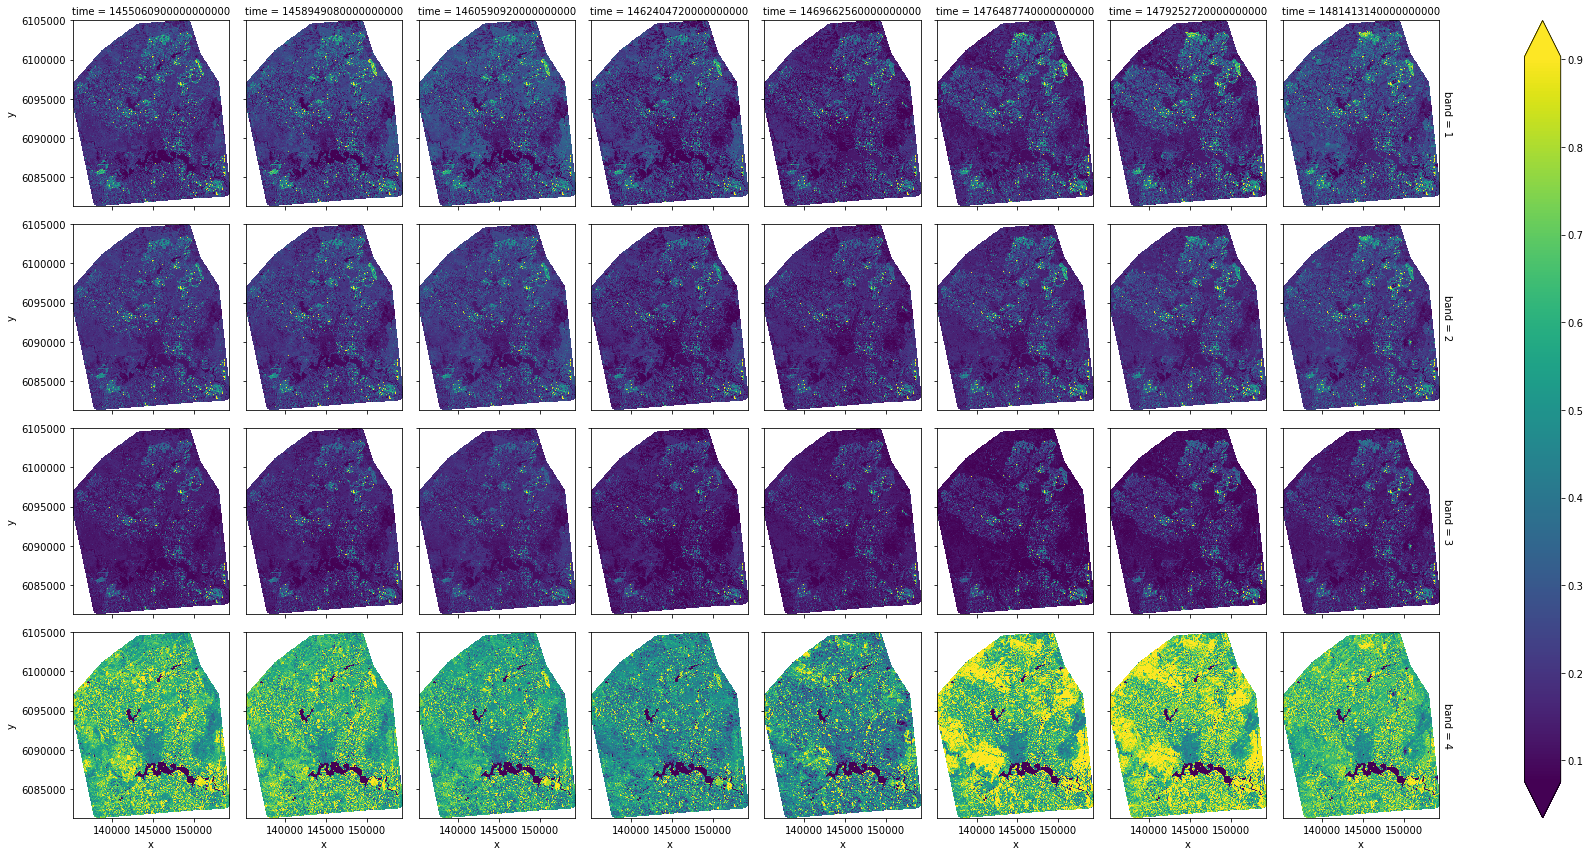

In [28]:
arr.isel(x=slice(None, None, 10), y=slice(None, None, 10)).plot.imshow(row='band', col='time', robust=True)

C:\UserData\hatfielz\Anaconda3\envs\remote-sensing\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


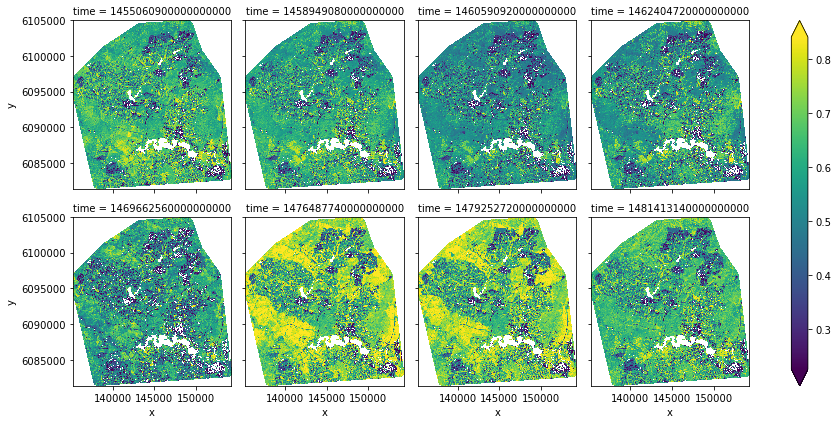

In [32]:
red = arr.sel(band=3)
nir = arr.sel(band=4)
ndvi = (nir - red) / (nir + red)
ndvi.values[ndvi.values < 0.15] = np.nan
ndvi.plot.imshow(col='time', robust=True, col_wrap=4)

In [37]:
ds = xr.Dataset(dict(radiance=arr, sensor=sensors))
ds.radiance.encoding = dict(shuffle=True, zlib=True, chunks=dict(x=400, y=400, time=4))
ds.to_netcdf('SPOT_canberra.nc')

In [38]:
imgs = sorted(glob.glob('namdagi/IMG_SPOT*.JP2'), key=lambda s: s.rsplit('_MS_')[-1])
imgs

['namdagi\\IMG_SPOT6_MS_201602152341097_ORT_2164426101_R1C1.JP2',
 'namdagi\\IMG_SPOT7_MS_201602212343091_ORT_2164425101_R1C1.JP2',
 'namdagi\\IMG_SPOT6_MS_201602272348164_ORT_2164414101_R1C1.JP2',
 'namdagi\\IMG_SPOT6_MS_201603052344389_ORT_2164413101_R1C1.JP2',
 'namdagi\\IMG_SPOT7_MS_201603182342567_ORT_2164412101_R1C1.JP2',
 'namdagi\\IMG_SPOT7_MS_201603252339069_ORT_2164427101_R1C1.JP2']

In [39]:
times = pd.to_datetime(
    [datetime.datetime(*time.strptime(os.path.basename(f)[13:25], '%Y%m%d%H%M')[:5]) for f in imgs]
).tz_localize('UTC')
times.name = 'time'
times

DatetimeIndex(['2016-02-15 23:41:00+00:00', '2016-02-21 23:43:00+00:00',
               '2016-02-27 23:48:00+00:00', '2016-03-05 23:44:00+00:00',
               '2016-03-18 23:42:00+00:00', '2016-03-25 23:39:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', freq=None)

In [40]:
sensors = pd.Series([os.path.basename(f)[4:9] for f in imgs], index=times)
sensors.name = 'sensor'
sensors

time
2016-02-15 23:41:00+00:00    SPOT6
2016-02-21 23:43:00+00:00    SPOT7
2016-02-27 23:48:00+00:00    SPOT6
2016-03-05 23:44:00+00:00    SPOT6
2016-03-18 23:42:00+00:00    SPOT7
2016-03-25 23:39:00+00:00    SPOT7
Name: sensor, dtype: object

In [41]:
ds = xr.concat([xr.open_rasterio(f).load() for f in imgs], times)
arr = ds / 2 ** 12
arr.values[arr.values == 0] = np.nan
arr

<xarray.DataArray (time: 6, band: 4, y: 2168, x: 2694)>
array([[[[ nan, ...,  nan],
         ..., 
         [ nan, ...,  nan]],

        ..., 
        [[ nan, ...,  nan],
         ..., 
         [ nan, ...,  nan]]],


       ..., 
       [[[ nan, ...,  nan],
         ..., 
         [ nan, ...,  nan]],

        ..., 
        [[ nan, ...,  nan],
         ..., 
         [ nan, ...,  nan]]]])
Coordinates:
  * band     (band) int32 1 2 3 4
  * y        (y) float64 6.059e+06 6.059e+06 6.059e+06 6.059e+06 6.059e+06 ...
  * x        (x) float64 1.151e+05 1.151e+05 1.151e+05 1.151e+05 1.151e+05 ...
  * time     (time) object 1455579660000000000 1456098180000000000 ...

In [42]:
ds = xr.Dataset(dict(radiance=arr, sensor=sensors))
ds.radiance.encoding = dict(shuffle=True, zlib=True, chunks=dict(x=400, y=400, time=4))
ds.to_netcdf('SPOT_namdagi.nc')